In [1]:
import numpy as np 
import pandas as pd
import sklearn
import time
import os
import shap
import re, pip, conda
import seaborn as sns # 用于特征重要性柱状图 Seaborn默认的图形样式和调色板使得绘图更美观，无需手动调整样式
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from scipy.interpolate import make_interp_spline # type: ignore
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve # 使用 roc_curve 函数计算 ROC 曲线的 FPR 和 TPR，并将这些数据存储为 pandas DataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, make_scorer


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# 定义模型
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LGBoost": LGBMClassifier(use_label_encoder=False),
    "CatBoost": CatBoostClassifier(verbose=0),
    "NGBoost": NGBClassifier()
}

In [3]:
# 读取数据
data1 = pd.read_excel(r'D:\Users\刘洋\Desktop\测试负2.xlsx')
X = data1.iloc[:, 1:12].values  # 取除最后一列之外的所有列作为特征
y = data1.iloc[:, 12].values   # 最后一列为标签

In [4]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# 数据标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# 自定义评分标准
scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

In [7]:
# 评估函数
def evaluate_model(model, X_train, y_train, X_test, y_test, cv):
    result = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring
                            , return_train_score=True
                            , verbose=False
                            )
    metrics = {
        "train": {
            "RCO-AUC": result['train_roc_auc'].mean(),
            "ACC": result['train_accuracy'].mean(),
            "F1": result['train_f1'].mean(),
            "Precision": result['train_precision'].mean(),
            "Recall": result['train_recall'].mean()
        },
        "test": {
            "RCO-AUC": roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
            "ACC": accuracy_score(y_test, model.predict(X_test)),
            "F1": f1_score(y_test, model.predict(X_test)),
            "Precision": precision_score(y_test, model.predict(X_test)),
            "Recall": recall_score(y_test, model.predict(X_test))
        }
    }
    return metrics

In [13]:
# 交叉验证并评估模型
results = {}
cv = KFold(n_splits=10, shuffle=True, random_state=1412)
for name, model in models.items():
    start = time.time()
   ####删减Pipeline后提升了LGB 同时NGB降低了0.02，影响不大
    model.fit(X_train, y_train)
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test, cv)
    end = time.time() - start
    metrics["time"] = end
    results[name] = metrics

[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Info] Number of positive: 82, number of negative: 87
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 169, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485207 -> initscore=-0.059189
[LightGBM] [Info] Start training from score -0.059189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

[iter 0] loss=0.6918 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.2825 val_loss=0.0000 scale=2.0000 norm=2.8251
[iter 200] loss=0.2338 val_loss=0.0000 scale=1.0000 norm=1.3510
[iter 300] loss=0.2138 val_loss=0.0000 scale=1.0000 norm=1.3230
[iter 400] loss=0.2032 val_loss=0.0000 scale=2.0000 norm=2.6153


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

[iter 0] loss=0.6928 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.2498 val_loss=0.0000 scale=2.0000 norm=2.7336
[iter 200] loss=0.2004 val_loss=0.0000 scale=2.0000 norm=2.6157
[iter 300] loss=0.1857 val_loss=0.0000 scale=1.0000 norm=1.2910
[iter 400] loss=0.1783 val_loss=0.0000 scale=1.0000 norm=1.2826


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

[iter 0] loss=0.6918 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.2967 val_loss=0.0000 scale=2.0000 norm=2.8836
[iter 200] loss=0.2371 val_loss=0.0000 scale=1.0000 norm=1.3791
[iter 300] loss=0.2220 val_loss=0.0000 scale=1.0000 norm=1.3639
[iter 400] loss=0.2147 val_loss=0.0000 scale=1.0000 norm=1.3557


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

[iter 0] loss=0.6928 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.2718 val_loss=0.0000 scale=2.0000 norm=2.8016
[iter 200] loss=0.2142 val_loss=0.0000 scale=1.0000 norm=1.3304
[iter 300] loss=0.1927 val_loss=0.0000 scale=0.5000 norm=0.6510
[iter 400] loss=0.1814 val_loss=0.0000 scale=0.2500 norm=0.3216


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.2942 val_loss=0.0000 scale=2.0000 norm=2.8479
[iter 200] loss=0.2262 val_loss=0.0000 scale=1.0000 norm=1.3446
[iter 300] loss=0.2057 val_loss=0.0000 scale=1.0000 norm=1.3196
[iter 400] loss=0.1944 val_loss=0.0000 scale=0.5000 norm=0.6524


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

[iter 0] loss=0.6928 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.2677 val_loss=0.0000 scale=2.0000 norm=2.7836
[iter 200] loss=0.2075 val_loss=0.0000 scale=1.0000 norm=1.3218
[iter 300] loss=0.1899 val_loss=0.0000 scale=1.0000 norm=1.3001
[iter 400] loss=0.1801 val_loss=0.0000 scale=1.0000 norm=1.2871


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

[iter 0] loss=0.6928 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.2451 val_loss=0.0000 scale=2.0000 norm=2.7691
[iter 200] loss=0.1943 val_loss=0.0000 scale=1.0000 norm=1.3218
[iter 300] loss=0.1767 val_loss=0.0000 scale=0.2500 norm=0.3245
[iter 400] loss=0.1699 val_loss=0.0000 scale=0.5000 norm=0.6441
[iter 0] loss=0.6928 val_loss=0.0000 scale=4.0000 norm=8.0000


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

[iter 100] loss=0.2981 val_loss=0.0000 scale=2.0000 norm=2.8618
[iter 200] loss=0.2522 val_loss=0.0000 scale=2.0000 norm=2.7652
[iter 300] loss=0.2322 val_loss=0.0000 scale=1.0000 norm=1.3607
[iter 400] loss=0.2208 val_loss=0.0000 scale=2.0000 norm=2.6970


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

[iter 0] loss=0.6926 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.2648 val_loss=0.0000 scale=2.0000 norm=2.7707
[iter 200] loss=0.2107 val_loss=0.0000 scale=1.0000 norm=1.3246
[iter 300] loss=0.1919 val_loss=0.0000 scale=1.0000 norm=1.3007
[iter 400] loss=0.1829 val_loss=0.0000 scale=0.5000 norm=0.6442


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

In [ ]:
# 交叉验证并评估模型   这里加了Pipeline  和上述代码一致
results = {}
cv = KFold(n_splits=10, shuffle=True, random_state=1412)
for name, model in models.items():
    start = time.time()
    # 使用Pipeline将标准化和模型训练结合
    pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', model)])##试着删减
    model.fit(X_train, y_train)
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test, cv)
    end = time.time() - start
    metrics["time"] = end
    results[name] = metrics

In [14]:
# 打印结果
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"Training time: {metrics['time']:.3f} s")
    for phase in ["train", "test"]:
        print(f"{phase.capitalize()} scores:")
        for metric, score in metrics[phase].items():
            print(f"  {metric}: {score:.3f}")
    print()

Model: XGBoost
Training time: 0.421 s
Train scores:
  RCO-AUC: 1.000
  ACC: 1.000
  F1: 1.000
  Precision: 1.000
  Recall: 1.000
Test scores:
  RCO-AUC: 0.851
  ACC: 0.767
  F1: 0.783
  Precision: 0.818
  Recall: 0.750

Model: LGBoost
Training time: 0.227 s
Train scores:
  RCO-AUC: 1.000
  ACC: 0.997
  F1: 0.997
  Precision: 0.995
  Recall: 0.999
Test scores:
  RCO-AUC: 0.833
  ACC: 0.744
  F1: 0.766
  Precision: 0.783
  Recall: 0.750

Model: CatBoost
Training time: 12.222 s
Train scores:
  RCO-AUC: 1.000
  ACC: 0.997
  F1: 0.997
  Precision: 0.999
  Recall: 0.995
Test scores:
  RCO-AUC: 0.886
  ACC: 0.814
  F1: 0.833
  Precision: 0.833
  Recall: 0.833

Model: NGBoost
Training time: 6.378 s
Train scores:
  RCO-AUC: nan
  ACC: 0.909
  F1: 0.909
  Precision: 0.879
  Recall: 0.942
Test scores:
  RCO-AUC: 0.874
  ACC: 0.814
  F1: 0.840
  Precision: 0.808
  Recall: 0.875



In [15]:
# 将结果保存到指定位置的表格中
rows = []
for name, metrics in results.items():
    for phase in ["train", "test"]:
        row = {
            'Model': name,
            'Phase': phase,
            'Training Time (s)': metrics['time'] if phase == 'train' else None
        }
        for metric, score in metrics[phase].items():
            row[metric] = score
        rows.append(row)

# 创建 DataFrame
df = pd.DataFrame(rows)

# 保存到 Excel 文件
output_path = r'D:\Users\刘洋\Desktop\未优化精度.xlsx'
df.to_excel(output_path, index=False)

print(f"Results have been saved to {output_path}")

Results have been saved to D:\Users\刘洋\Desktop\未优化精度.xlsx


In [16]:
# 绘制所有模型的ROC曲线
plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')

# 添加图例和图形的标签
plt.plot([0, 1], [0, 1], 'k--',linewidth=1)  # 参考线：随机分类器的ROC曲线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig(r'D:\Users\刘洋\Desktop\未优化ROC.png')
plt.close()  # 关闭图像以确保保存后不会影响后续图形的显示

[LightGBM] [Warning] Unknown parameter: use_label_encoder


In [ ]:
# SHAP 模型解释
feature_names = data1.columns[:-1]  # 获取特征名称

for name, model in models.items():
    if name in ["XGBoost", "LGBoost", "CatBoost"]:  # 仅对支持的树模型进行 SHAP 解释
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        
        # 绘制 SHAP 值总结图
        print(f"SHAP summary for {name}:")
        shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", show=False)
        plt.savefig(fr'D:\Users\刘洋\Desktop\SHAP_Summary_{name}.png')
        plt.close()  # 关闭图像以确保保存后不会影响后续图形的显示
        
    elif name == "NGBoost":  # 对 NGBoost 模型进行 SHAP 解释
        explainer = shap.Explainer(model.predict, X_train)  # 使用模型的预测函数进行解释
        shap_values = explainer(X_test)
        
        # 绘制 SHAP 值总结图
        print(f"SHAP summary for {name}:")
        shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", show=False)
        plt.savefig(fr'D:\Users\刘洋\Desktop\SHAP_Summary_{name}.png')
        plt.close()  # 关闭图像以确保保存后不会影响后续图形的显示

In [17]:
# SHAP 模型解释
feature_names = data1.columns[1:-1]  # 获取特征名称

for name, model in models.items():
    if name in ["XGBoost", "LGBoost", "CatBoost"]:  # 仅对支持的树模型进行 SHAP 解释
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        
        # 绘制 SHAP 值总结图
        print(f"SHAP summary for {name}:")
        shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", show=False)
        plt.savefig(fr'D:\Users\刘洋\Desktop\SHAP_Summary_{name}.png')
        plt.close()  # 关闭图像以确保保存后不会影响后续图形的显示
        
        # 绘制 SHAP 散点图
        if isinstance(shap_values, list):
            for i in range(len(shap_values)):
                shap.summary_plot(shap_values[i], X_test, feature_names=feature_names, plot_type="dot", show=False)
                plt.savefig(fr'D:\Users\刘洋\Desktop\SHAP_Scatter_{name}_class_{i}.png')
                plt.close()  # 关闭图像以确保保存后不会影响后续图形的显示
        else:
            shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="dot", show=False)
            plt.savefig(fr'D:\Users\刘洋\Desktop\SHAP_Scatter_{name}.png')
            plt.close()  # 关闭图像以确保保存后不会影响后续图形的显示
    elif name == "NGBoost":  # 对 NGBoost 模型进行 SHAP 解释
        explainer = shap.Explainer(model.predict, X_train)  # 使用模型的预测函数进行解释
        shap_values = explainer(X_test)
        
        # 绘制 SHAP 值总结图
        print(f"SHAP summary for {name}:")
        shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", show=False)
        plt.savefig(fr'D:\Users\刘洋\Desktop\SHAP_Summary_{name}.png')
        plt.close()  # 关闭图像以确保保存后不会影响后续图形的显示
        
        # 绘制 SHAP 散点图
        shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="dot", show=False)
        plt.savefig(fr'D:\Users\刘洋\Desktop\SHAP_Scatter_{name}.png')
        plt.close()  # 关闭图像以确保保存后不会影响后续图形的显示

[11:17:20] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


SHAP summary for XGBoost:


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


SHAP summary for LGBoost:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


SHAP summary for CatBoost:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Permutation explainer: 44it [00:54,  1.50s/it]                        
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


SHAP summary for NGBoost:


In [ ]:
# 加载全部研究区数据     错误的代码，没用的代码先保留
all_data = pd.read_excel(r'D:\Users\刘洋\Desktop\无坐标.xlsx')
X_all = all_data.iloc[:, 1:11].values  # 2到12列为特征
y_all = all_data.iloc[:, 11].values    # 13列为标签
# 对全部研究区数据进行预测并保存结果
results = pd.DataFrame()
for name, model in models.items():
    y_pred_all = model.predict(X_all)
    y_pred_proba_all = model.predict_proba(X_all)[:, 1]
    results[f'{name}_prediction'] = y_pred_all
    results[f'{name}_probability'] = y_pred_proba_all

results['true_label'] = y_all
results.to_excel(r'D:\Users\刘洋\Desktop\研究区预测.xlsx', index=False)  # 保存预测结果

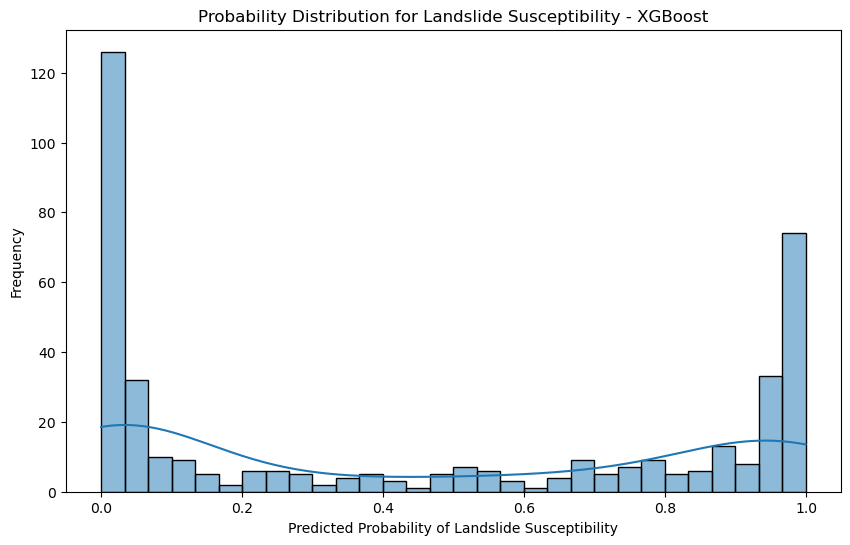

Probability Statistics for XGBoost Model:
  Mean: 0.449
  Standard Deviation: 0.417
  Min: 0.000
  Max: 0.999

[LightGBM] [Warning] Unknown parameter: use_label_encoder


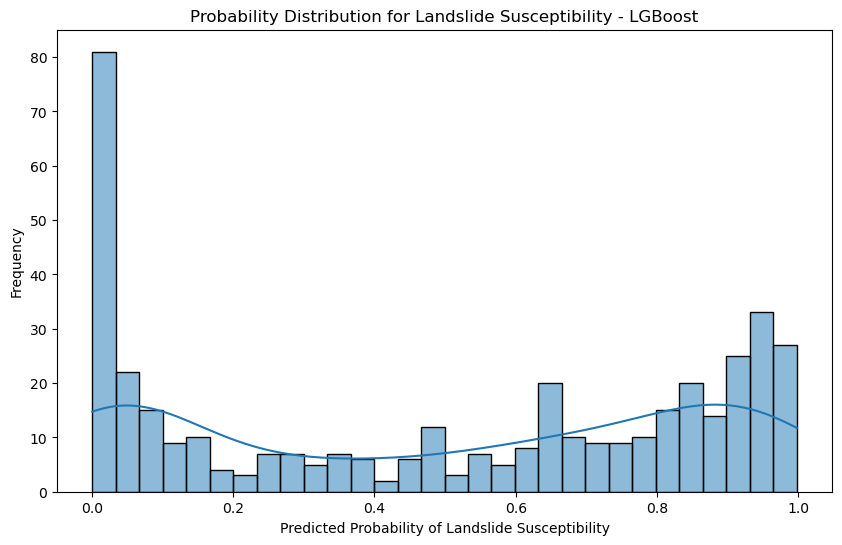

Probability Statistics for LGBoost Model:
  Mean: 0.494
  Standard Deviation: 0.371
  Min: 0.001
  Max: 0.998



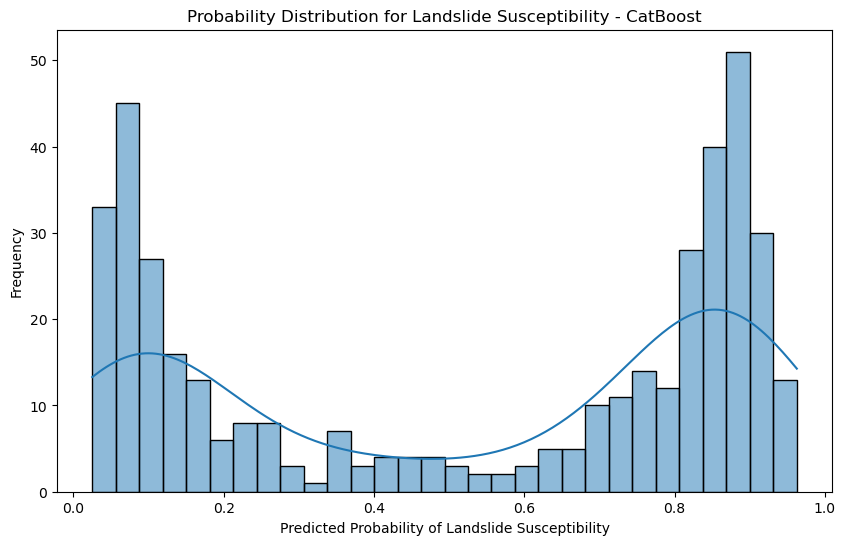

Probability Statistics for CatBoost Model:
  Mean: 0.526
  Standard Deviation: 0.353
  Min: 0.025
  Max: 0.963



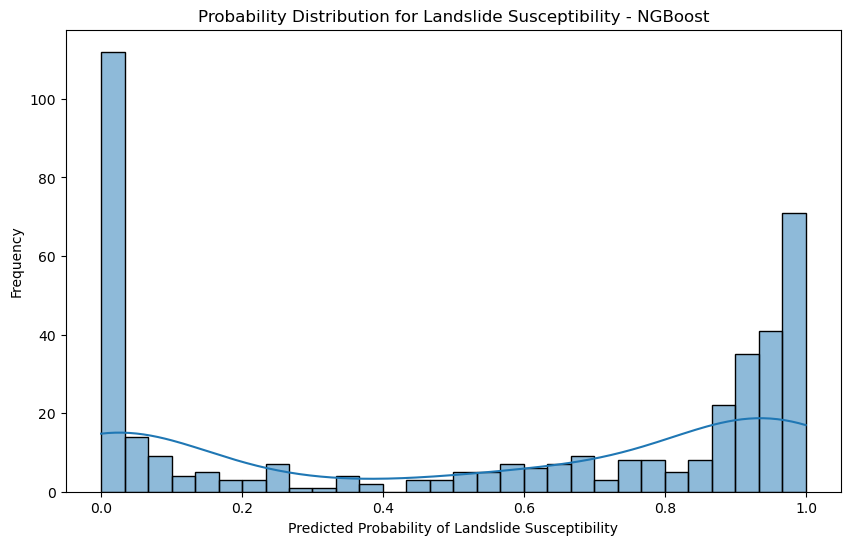

Probability Statistics for NGBoost Model:
  Mean: 0.540
  Standard Deviation: 0.418
  Min: 0.000
  Max: 0.999

Combined probability predictions have been saved to D:\Users\刘洋\Desktop\未优化概率预测.csv


In [21]:
# 读取研究区数据
all_data = pd.read_excel(r'D:\Users\刘洋\Desktop\无坐标.xlsx')
X_all = all_data.iloc[:, 1:12].values  # 第2到12列为特征值，共计11列

# 数据标准化
scaler_all = StandardScaler()
X_all = scaler_all.fit_transform(X_all)

# 初始化用于保存所有模型预测概率的 DataFrame
probabilities_df = pd.DataFrame(index=all_data.index)

# 对研究区数据进行概率预测
for name, model in models.items():
    # 使用之前训练好的模型对研究区数据进行预测
    try:
        y_prob_all = model.predict_proba(X_all)[:, 1]  # 获取研究区数据属于“正例”（滑坡易发）的概率
    except AttributeError:
        # 如果模型未训练，进行训练（使用训练集数据）
        data1 = pd.read_excel(r'D:\Users\刘洋\Desktop\测试负2.xlsx', index_col=0)
        X = data1.iloc[:, 0:-1].values  # 取除最后一列之外的所有列作为特征
        y = data1.iloc[:, -1].values  # 最后一列为标签
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model.fit(X_train, y_train)
        y_prob_all = model.predict_proba(X_all)[:, 1]
    
    # 将预测概率添加到 DataFrame 中
    probabilities_df[name] = y_prob_all
    
    # 绘制研究区数据的概率分布
    plt.figure(figsize=(10, 6))
    sns.histplot(y_prob_all, kde=True, bins=30)
    plt.title(f'Probability Distribution for Landslide Susceptibility - {name}')
    plt.xlabel('Predicted Probability of Landslide Susceptibility')
    plt.ylabel('Frequency')
    plt.show()

    # 输出概率预测的基本统计信息
    print(f"Probability Statistics for {name} Model:")
    print(f"  Mean: {np.mean(y_prob_all):.3f}")
    print(f"  Standard Deviation: {np.std(y_prob_all):.3f}")
    print(f"  Min: {np.min(y_prob_all):.3f}")
    print(f"  Max: {np.max(y_prob_all):.3f}")
    print()

# 将所有模型的概率预测结果输出到 Excel 文件
output_path = r'D:\Users\刘洋\Desktop\未优化概率预测.csv'
probabilities_df.to_csv(output_path)
print(f"Combined probability predictions have been saved to {output_path}")